In [1]:
import math
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry
from geopy.distance import geodesic
from quetzal.model import stepmodel

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

# Preparation of the LoS tables
## Saves a StepModel with shortest paths and LoS attributes for the road network
## Needs the road network

In [2]:
input_path = '../input_static/'
output_path = '../output/'
model_path = '../model/'

In [3]:
sm = stepmodel.read_json(model_path + 'de_road_network')
ae = stepmodel.read_json(model_path + 'de_road_access_egress')

In [4]:
sm.zone_to_road = ae.zone_to_road
sm.centroids = ae.centroids

## Generate LoS attribute time
The maxspeed column is based on OSM data that needs to be refined. The unit is km/h

In [5]:
sm.road_links["length"] = pd.to_numeric(sm.road_links["length"])

In [6]:
default_speed = 0

In [7]:
def get_vmax(s):
    v_max = default_speed
    if isinstance(s, str):
        if s.startswith("["):
            v_list_str = s[1:-1].split(", ")
            v_list_str = [v[1:-1] for v in v_list_str]
            v_list = []
            for v in v_list_str:
                try:
                    v_list.append(int(v))
                except ValueError:
                    pass
            try:
                v_max = max(v_list)
            except ValueError:
                pass
        else:
            try:
                v_max = int(s)
            except ValueError:
                pass
    elif isinstance(s, int) or isinstance(s, float):
        v_max = s
    return v_max
sm.road_links["maxspeed"] = sm.road_links["maxspeed"].apply(get_vmax)
sm.road_links["maxspeed"].fillna(default_speed, inplace=True, downcast='infer')

In [8]:
# Length of road network
sm.road_links['length'].sum()/1000

549916.399

In [9]:
# Length of road network without any speed assigned
sm.road_links.loc[sm.road_links['maxspeed']==default_speed]['length'].sum()/1000

425040.673

In [10]:
# Length of road network with multiple highway classifications
sm.road_links.loc[sm.road_links['highway'].str.startswith('[')]['length'].sum()/1000

7539.478

In [11]:
# Length of unclassified road network
sm.road_links.loc[sm.road_links['highway']=='unclassified']['length'].sum()/1000

0.0

array([[<AxesSubplot:title={'center':'maxspeed'}>]], dtype=object)

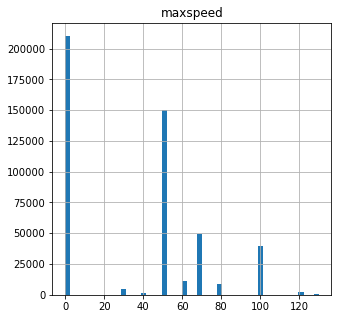

In [12]:
# Number of links (not length) with specified speeds
sm.road_links.hist(column='maxspeed', bins=50, figsize=(5,5))

In [13]:
sm.road_links['highway'].unique()

array(['trunk', 'secondary', 'primary', 'motorway_link', 'trunk_link',
       'primary_link', "['trunk', 'primary']", 'motorway',
       'secondary_link', "['secondary', 'trunk_link']",
       "['secondary', 'secondary_link']",
       "['secondary', 'motorway_link']", "['primary', 'trunk_link']",
       "['primary_link', 'primary']", "['secondary', 'primary_link']",
       "['motorway', 'trunk']", "['motorway', 'motorway_link']",
       "['trunk_link', 'motorway_link']", "['motorway', 'primary']",
       "['trunk', 'trunk_link']", "['trunk', 'motorway_link']",
       "['primary', 'motorway_link']", "['secondary_link', 'trunk_link']",
       "['trunk_link', 'primary']", "['primary_link', 'secondary_link']",
       "['primary_link', 'trunk_link']",
       "['secondary', 'primary_link', 'secondary_link']",
       "['secondary', 'trunk']", "['secondary_link', 'motorway_link']",
       "['secondary', 'primary']", "['motorway', 'trunk', 'primary']",
       "['primary_link', 'motorway_link']"

In [14]:
main_types = [t for t in list(sm.road_links['highway'].unique()) if not t.startswith('[')]
temp = sm.road_links.loc[(sm.road_links['maxspeed']!=default_speed) &
                         (sm.road_links['highway'].isin(main_types))
                        ].set_index('highway', drop=True)
weighted_speeds = temp.groupby(temp.index).apply(
    lambda x: int(np.average(x.maxspeed, weights=x.length)))
weighted_speeds

highway
motorway          112
motorway_link      80
primary            68
primary_link       68
secondary          57
secondary_link     60
trunk              96
trunk_link         70
dtype: int64

In [15]:
weighted_speeds.mean()

76.375

In [16]:
# On German motorways without speed limit MIV average speed is 125 km/h
# https://www.zukunft-mobilitaet.net/171117/analyse/gefahrene-geschwindigkeiten-auf-autobahnen-ohne-tempolimit-verteilung-deutschland/
sm.road_links.loc[(sm.road_links['maxspeed']==default_speed) &
                  (sm.road_links['highway']=='motorway'), 'maxspeed'] = 125
# All other road types are attributed according to the mean speed limit for their type
main_types = [t for t in list(sm.road_links['highway'].unique()) if not t.startswith('[')]
for t in main_types:
    try:
        sm.road_links.loc[(sm.road_links['maxspeed']==default_speed) &
                          (sm.road_links['highway']==t), 'maxspeed'] = weighted_speeds[t]
    except KeyError:
        print('No benchmark speed for highway type ' + t)
# The rest is a mix of all road types
sm.road_links['maxspeed'] = sm.road_links['maxspeed'].replace(
    default_speed, int(weighted_speeds.mean()))

array([[<AxesSubplot:title={'center':'maxspeed'}>]], dtype=object)

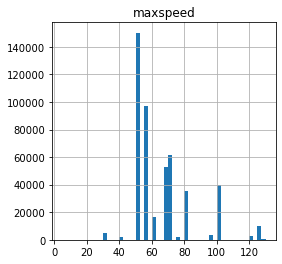

In [17]:
# Number of links (not length) with specified speeds
sm.road_links.hist(column='maxspeed', bins=50, figsize=(4,4))

In [18]:
# Generate time for road links in seconds
# Manual calibration with Google maps (see below)
# shows that traffic flow is slower than the speed limits
road_speed_calibration = 0.8
sm.road_links["time"] = sm.road_links["length"] / 1000 / \
    (sm.road_links["maxspeed"] * road_speed_calibration) * 3600

In [19]:
sm.road_links.sample(4)

,a,b,geometry,maxspeed,lanes,highway,length,time
index,,,,,,,,
rl_289707,457938,38443858,"LINESTRING (6.91715 50.96925, 6.91776 50.96965)",50,3,secondary,61,5.490000
rl_467265,256141939,62316354,"LINESTRING (9.95991 47.63598, 10.00203 47.61397)",57,None,secondary,5208,411.157895
rl_13744,1598050944,25777766,"LINESTRING (7.17671 50.95697, 7.17071 50.95539)",80,1,motorway_link,462,25.987500
rl_461793,3265511745,1327929999,"LINESTRING (12.33505 50.84673, 12.33439 50.84850)",70,"[3, 2]",secondary,202,12.985714


### Alter road access/egress links

In [20]:
# There has been assigned a static time value in prep20?
sm.zone_to_road.sample()

,a,b,direction,distance,speed,time,geometry
index,,,,,,,
525,1634494213,DEG0K,eggress,0,17,0,"LINESTRING (11.71058 50.58075, 11.73166 50.50189)"


In [21]:
# ASSUMPTION: Assign a time
sm.zone_to_road['time'] = int(5*60)

In [22]:
# If zones have been split, there is no road connection
# to the island of Sylt. However, there is a car train
# https://www.autozug-sylt.de/de/preise/normaltarif/
# https://www.syltshuttle.de/syltshuttle-de/fahrkarten/tarif_2021-2049320
# Waiting time depends on the time of the day (10 minutes to 3 hours)
p = 44
t = int((35 + 60 + 10)*60)
g = sm.road_nodes.loc['3911057351', 'geometry']
c = sm.centroids.loc['DEF07_2', 'geometry']
d = int(geodesic(g.coords, c.coords).m)
sm.zone_to_road.loc[len(sm.zone_to_road)] = \
    ['DEF07_2', '3911057351', 'access', d, int(d/t*3.6), t, geometry.LineString([c, g])]
sm.zone_to_road.loc[len(sm.zone_to_road)] = \
    ['3911057351', 'DEF07_2', 'eggress', d, int(d/t*3.6), t, geometry.LineString([g, c])]

In [23]:
sm.zone_to_road.loc[(sm.zone_to_road['b']=='DEF07_2')|(sm.zone_to_road['a']=='DEF07_2')]

,a,b,direction,distance,speed,time,geometry
index,,,,,,,
932,DEF07_2,3911057351,access,53595,30,6300,LINESTRING (8.361925876393382 54.9115089133736...
933,3911057351,DEF07_2,eggress,53595,30,6300,"LINESTRING (8.828914899999999 54.7814695, 8.36..."


## Apply road pathfinder in order to generate LoS table

In [24]:
# Load OD pairs from volumes if available
od_set = None
try:
    v = stepmodel.read_json(model_path + 'de_volumes')
    od_set = set([tuple(l) for l in v.volumes[['origin', 'destination']].values.tolist()])
    print('Generated OD set with {} pairs'.format(len(od_set)))
except:
    print('The volumes file is not (yet) available')

Generated OD set with 217335 pairs


In [25]:
sm.step_road_pathfinder(all_or_nothing=True,
                        od_set=od_set)

In [26]:
sm.car_los.sample(3)

,origin,destination,time,path,node_path,link_path,ntlegs
68486,DE268,DEA26,14481.108379,"[DE268, 29080012, 29080001, 29080000, 30166110...","[29080012, 29080001, 29080000, 3016611022, 227...","[rl_406842, rl_157407, rl_447020, rl_468012, r...","[(DE268, 29080012), (5931463741, DEA26)]"
99785,DE731,DEA32,8568.330751,"[DE731, 3987755952, 1959256947, 32856421, 3285...","[3987755952, 1959256947, 32856421, 32856416, 2...","[rl_13940, rl_328586, rl_437620, rl_422507, rl...","[(DE731, 3987755952), (1599916033, DEA32)]"
6933,DE121,DED2C_2,24488.963158,"[DE121, 32131210, 31261453, 17558612, 53479529...","[32131210, 31261453, 17558612, 5347952995, 193...","[rl_431242, rl_410709, rl_398021, rl_138529, r...","[(DE121, 32131210), (260806127, DED2C_2)]"


In [27]:
sm.car_los.shape

(217335, 7)

In [28]:
# Verify with Google maps routing
# Berlin (DE300) - Stade (DE939): 4h22m, 354km
# Berlin (DE300) - Stuttgart (DE111): 6h37m, 632km
# Berlin (DE300) - Stendal (DEE0D): 2h08m, 125km
# Stade - Stuttgart: 7h45m, 687km
# Stendal - Stuttgart: 6h11m, 574km
# Stendal - Stade: 3h22m, 231km
od = ['DE300_1', 'DE939', 'DE111', 'DEE0D']
for _, row in sm.car_los.loc[(sm.car_los['origin'].isin(od)) &
                             (sm.car_los['destination'].isin(od))].iterrows():
    print(row['origin'] + ' - ' + row['destination'] + ': '
          + str(np.round(row['time']/3600,1)) + ', '
          + str(int(sm.road_links.loc[row['link_path'], 'length'].sum()/1000)) + 'km')

DE111 - DE111: 0.0, 0km
DE111 - DE300_1: 6.7, 623km
DE111 - DE939: 7.7, 689km
DE111 - DEE0D: 7.1, 576km
DE300_1 - DE111: 6.7, 623km
DE300_1 - DE300_1: 0.0, 0km
DE300_1 - DE939: 4.1, 351km
DE300_1 - DEE0D: 2.2, 113km
DE939 - DE111: 7.7, 688km
DE939 - DE300_1: 4.1, 351km
DE939 - DE939: 0.0, 0km
DE939 - DEE0D: 4.0, 290km
DEE0D - DE111: 7.2, 587km
DEE0D - DE300_1: 2.4, 124km
DEE0D - DE939: 3.6, 273km
DEE0D - DEE0D: 0.0, 0km


array([[<AxesSubplot:title={'center':'time'}>]], dtype=object)

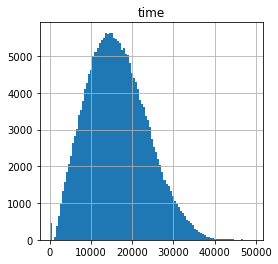

In [29]:
sm.car_los.hist(column='time', bins=100, figsize=(4,4))

In [30]:
# Drop inner-cell connections
sm.car_los = sm.car_los[sm.car_los['time']!=0]
sm.car_los.shape

(216869, 7)

## Add various attributes to LoS table

In [31]:
# Disaggregate into in-vehicle time and access/egress
sm.analysis_car_time()
print(sm.car_los.columns)

Index(['origin', 'destination', 'time', 'path', 'node_path', 'link_path',
       'ntlegs', 'access_time', 'in_vehicle_time'],
      dtype='object')


In [32]:
# Add distances car
len_dict = sm.road_links['length'].to_dict()
sm.car_los['length'] = sm.car_los['link_path'].apply(lambda p: sum([len_dict[l] for l in p]))

In [33]:
# Add route_type = 'car' in car_los
sm.analysis_car_route_type()

In [34]:
sm.car_los['ntransfers'] = 0

In [35]:
# Car is always available
sm.car_los['accessibility'] = 1

### Car ownership and accessibility
Car ownership from the German federal statistical office GENESIS data base table 46251-0006: "Kraftfahrzeugbestand: Kreise, Stichtag, Kraftfahrzeugarten". Download at Nov. 26th 2020. License: Datenlizenz by-2-0; www.govdata.de/dl-de/by-2-0

In [36]:
# Load the table
cars = pd.read_excel(input_path + 'spatial_car_ownership_2017_GENESIS.xlsx')
cars['sum_MIT'] = cars['Krafträder'] + cars['Pkw']
cars['lau_id'] = cars['lau_id'].astype(str)
cars['sum_MIT'] = cars['sum_MIT'].replace({'--': 0}).astype(int)
cars.set_index('lau_id', drop=True, inplace=True)
lau_car_dict = cars['sum_MIT'].to_dict()
sm.zones['cars'] = sm.zones['lau_id'].map(lau_car_dict)
sm.zones.sample(2)

,CNTR_CODE,NUTS_NAME,LEVL_CODE,FID,NUTS_ID,population,area,urbanisation,lau_id,geometry,cars
index,,,,,,,,,,,
DE21C,DE,Fürstenfeldbruck,3,DE21C,DE21C,219320,434.81,3.0,9179,"POLYGON ((11.40294 48.20312, 11.39299 48.20051...",132085.0
DED2F,DE,Sächsische Schweiz-Osterzgebirge,3,DED2F,DED2F,245611,1654.19,3.0,14628,"POLYGON ((14.31787 51.05470, 14.30141 51.05442...",152170.0


In [37]:
# Weigh the number of cars by population if zone has been split
def weighted_cars(g):
    pop_sum = g['population'].sum()
    cars = max(list(g['cars']))
    pop = list(g['population'])
    weighted_cars = [cars * pop[i] / pop_sum for i in range(len(pop))]
    return pd.Series(index=g.index, data=weighted_cars)
mask = sm.zones['NUTS_ID']!=sm.zones['FID']
shares = sm.zones.loc[mask].groupby('NUTS_ID').apply(weighted_cars).reset_index(level=0, drop=True)
sm.zones.loc[mask, 'cars'] = shares

In [38]:
# Empty rows
sm.zones.loc[sm.zones['cars'].isna()]

,CNTR_CODE,NUTS_NAME,LEVL_CODE,FID,NUTS_ID,population,area,urbanisation,lau_id,geometry,cars
index,,,,,,,,,,,
DE929_city,DE,Hannover,3,DE929_city,DE929,268224,204.300000,1.0,3241001,"POLYGON ((9.78861 52.37444, 9.78837 52.36954, ...",NaN
DE929_1,DE,Region Hannover 1,3,DE929_1,DE929,410987,1082.811956,2.0,3241,"POLYGON ((9.71914 52.19921, 9.69952 52.19807, ...",NaN
DE929_2,DE,Region Hannover 2,3,DE929_2,DE929,478411,1010.018044,2.0,3241,"POLYGON ((9.73462 52.63830, 9.74099 52.63166, ...",NaN


In [39]:
sm.zones.loc[sm.zones['cars'].isna(), 'cars'] = 0

In [40]:
# Unrealistic rows
sm.zones.loc[sm.zones['cars']<sm.zones['population']/3]

,CNTR_CODE,NUTS_NAME,LEVL_CODE,FID,NUTS_ID,population,area,urbanisation,lau_id,geometry,cars
index,,,,,,,,,,,
DE929_city,DE,Hannover,3,DE929_city,DE929,268224,204.300000,1.0,3241001,"POLYGON ((9.78861 52.37444, 9.78837 52.36954, ...",0.0
DE91C_1,DE,Göttingen 1,3,DE91C_1,DE91C,124686,985.217771,3.0,3159,"POLYGON ((10.67728 51.63838, 10.67664 51.63294...",0.0
DE91C_2,DE,Göttingen 2,3,DE91C_2,DE91C,203387,770.172229,3.0,3159,"POLYGON ((10.08480 51.43496, 10.08309 51.43485...",0.0
DE929_1,DE,Region Hannover 1,3,DE929_1,DE929,410987,1082.811956,2.0,3241,"POLYGON ((9.71914 52.19921, 9.69952 52.19807, ...",0.0
DE929_2,DE,Region Hannover 2,3,DE929_2,DE929,478411,1010.018044,2.0,3241,"POLYGON ((9.73462 52.63830, 9.74099 52.63166, ...",0.0
DEB25_1,DE,Trier-Saarburg 1,3,DEB25_1,DEB25,81269,580.745748,3.0,7235,"POLYGON ((6.78257 49.57311, 6.78173 49.57253, ...",0.0
DEB25_2,DE,Trier-Saarburg 2,3,DEB25_2,DEB25,67675,521.474252,3.0,7235,"POLYGON ((6.71195 49.90481, 6.72201 49.89223, ...",0.0


Accessibility of cars is important for only those people who drive them. If I wanted to calculate it using only the population between age 18 and 75, I had to use different numbers for population.

Population by NUTS3 zone and age group from the German federal statistical office GENESIS data base table 12411-0017: "Bevölkerung: Kreise, Stichtag, Altersgruppen". Download at Jan. 29th 2021. License: Datenlizenz by-2-0; www.govdata.de/dl-de/by-2-0

In [41]:
# Replace empty rows with average density
sm.zones['car_density'] = sm.zones['cars'] / sm.zones['population']
sm.zones.loc[sm.zones['cars']==0, 'cars'] = \
    sm.zones['car_density'].mean() * sm.zones.loc[sm.zones['cars']==0, 'population']
sm.zones['car_density'] = sm.zones['cars'] / sm.zones['population']

In [42]:
sm.zones['cars'] = sm.zones['cars'].astype(int)

In [43]:
sm.zones.groupby('urbanisation').agg({'car_density': 'mean'})

,car_density
urbanisation,
1.0,0.534436
2.0,0.656584
3.0,0.672680


In [44]:
# Set accessibility
ac_dict = sm.zones['car_density'].to_dict()
sm.car_los['accessibility'] = sm.car_los['origin'].map(ac_dict)

In [45]:
# There are two cities with more cars than inhabitants
# However, accessibility cannot be larger 1
sm.car_los['accessibility'] = sm.car_los['accessibility'].apply(lambda a: min(1, a))

array([[<AxesSubplot:title={'center':'accessibility'}>]], dtype=object)

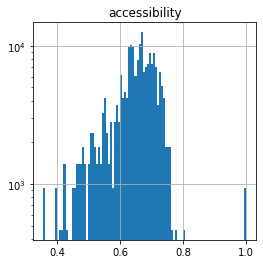

In [46]:
sm.car_los.hist(column='accessibility', bins=100, figsize=(4,4), log=True)

### Add cost to LoS table

In [47]:
def monetary_cost(length, rf, vc, ac, al, ec, el, sf):
    """ calculate monetary cost of travelling one O-D realtion within the LoS table
    :param length: length of main leg in meter
    :param df: regression factor for length (to be calibrated beforehand)
    :param vc: distance-specific transport cost
    :param ac: access cost
    :param al: access link length (m)
    :param ec: egress cost
    :param el: egress link length (m)
    :param sf: sharing factor (e.g. occupancy factor of a car)
    :return: monetary cost"""
    return (math.pow(length, rf) * vc + ac * al + ec * el) / sf

In [48]:
# Load list of cost elements
cars = pd.read_csv(input_path + 'level_of_service_ADAC_2019_autokostenuebersicht_47085.csv')
cars.sample(4)

,fix_cost,repair_cost,var_cost,acquisition_cost,eur_per_month,ct_per_km,model,model.1
868,167,134,189,717,1207,96.6,SLC 43 AMG 9G-TRONIC,SLC 43 AMG 9G-TRONIC
1377,95,47,115,190,447,35.8,Yaris 1.5 Comfort,Yaris 1.5 Comfort
1063,143,83,130,484,840,67.2,NV300 Kombi L1H1 dCi 120 Comfort,NV300 Kombi L1H1 dCi 120 Comfort
1238,126,71,104,326,627,50.2,Mégane Grandtour BLUE dCi 150 Business Edition...,Mégane Grandtour BLUE dCi 150 Business Edition...


Take only perceived variable cost for distance-dependency.<br>
Assume monthly mileage of 15,000km / 12<br>
Additionally, there are fix cost which add up on every trip. Assume 3 trips per day as average.

In [49]:
# Prep
sm.car_los['price'] = 0
vc_car = cars['var_cost'].astype(int).mean() / (15000000/12) # in EUR/m
fix_car = cars['fix_cost'].astype(int).mean() / 30 / 3
parking_cost = {1: 5, 2: 1, 3: 0} # cost depending on urbanisation degree
print(fix_car)
print(vc_car)

1.551890814081408
0.00011439257425742574


Car occupancy depends on distance

The linear fit of MiD2017 car trips yields this function
`car: n_persons = 0.0024 * distance[km] + 1.692`

In [50]:
# Add prices
sm.car_los['price'] = sm.car_los.apply(lambda df: monetary_cost(
    df['length'], 1, vc_car,
    0,0, #parking_cost[sm.zones.loc[df['origin']]['urbanisation']], 1,
    0,0, #parking_cost[sm.zones.loc[df['destination']]['urbanisation']], 1,
    0.0024*df['length']/1000+1.692) + fix_car, axis=1)

In [51]:
# Alternative ASSUMPTION: Average car occupancy is 1.5 in Germany
sm.car_los['price'] = sm.car_los.apply(lambda df: monetary_cost(
    df['length'], 1, vc_car,
    0,0, #parking_cost[sm.zones.loc[df['origin']]['urbanisation']], 1,
    0,0, #parking_cost[sm.zones.loc[df['destination']]['urbanisation']], 1,
    1.5) + fix_car, axis=1)

In [52]:
sm.car_los.sample(2)

,origin,destination,time,path,node_path,link_path,ntlegs,access_time,in_vehicle_time,length,route_types,route_type,ntransfers,accessibility,price
205738,DEF0F,DE933,2737.668696,"[DEF0F, 90143523, 1921735924, 90143581, 901435...","[90143523, 1921735924, 90143581, 90143500, 901...","[rl_399403, rl_479638, rl_311106, rl_479604, r...","[(DEF0F, 90143523), (94103871, DE933)]",600,2137.668696,53053,"(car,)",car,0,0.653333,5.597804
49169,DE239,DE259,4375.137472,"[DE239, 475874278, 475874312, 270381204, 13878...","[475874278, 475874312, 270381204, 13878038, 47...","[rl_218766, rl_218780, rl_236388, rl_159139, r...","[(DE239, 475874278), (6106778973, DE259)]",600,3775.137472,93634,"(car,)",car,0,0.739933,8.692580


<AxesSubplot:xlabel='length', ylabel='price'>

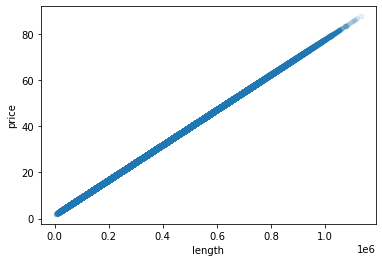

In [53]:
sm.car_los.plot.scatter(x='length', y='price', alpha=.1)

Instead of fix cost per trip, one can also assume ownership cost per hour of vehicle usage. This is also the approach chosen for the German federal governments transport study. In the methodical handbook gasoline cars have engine class weighted specific ownership cost of 0.71 EUR/h and diesel cars 0.99 EUR/h (other propulsion systems don't play a significant role). Multiplied with 2017's shares of gasoline and diesel cars (66.5%; 33.5%) this yields weighted average ownership cost of 0.8 EUR/h.

In [54]:
sm.car_los['price'] = sm.car_los['price'] - fix_car + \
    sm.car_los['time'].apply(lambda s: 0.8 * s / 3600)

<AxesSubplot:xlabel='length', ylabel='price'>

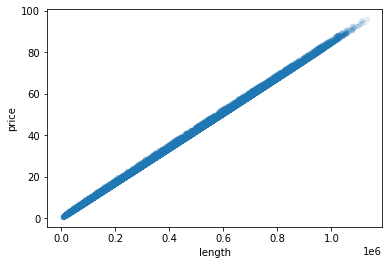

In [55]:
sm.car_los.plot.scatter(x='length', y='price', alpha=.1)

### Save model

In [56]:
# Ditch unneccessary columns
to_drop = ['alighting_links','alightings','all_walk','boarding_links','boardings',
           'footpaths','length_link_path','node_path','ntlegs','time_link_path','transfers',
           'pathfinder_session','gtime','reversed', 'broken_modes', 'path']
sm.car_los = sm.car_los.drop(to_drop, axis=1, errors='ignore')

In [57]:
# Make table smaller
cols = ['time', 'access_time', 'in_vehicle_time', 'length']
sm.car_los[cols] = sm.car_los[cols].astype(int)

In [58]:
sm.to_json(model_path + 'de_road_los',
           only_attributes=['car_los'], encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 34/34 [00:16<00:00,  2.01it/s]
